# DAARIO 101 (on a single modality)


As our first tutorial we will use a great single cell tutorial classic. Probably the most analyzed dataset in our solar system, our beloved pbmc3k.As our first tutorial we will use a great single cell tutorial classic. Probably the most analyzed dataset in our solar system, our beloved pbmc3k. It needs no introduction, but just in case, it is a dataset of 3000 blood mononuclear cells, sequenced with 3' 10X technology. 

In [1]:
import sys
sys.path.append("/home/salvatore.milite/work/python_packages/daario/src/")

%load_ext autoreload
%autoreload 2

In [2]:
import daario as daa

import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
adata =  sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


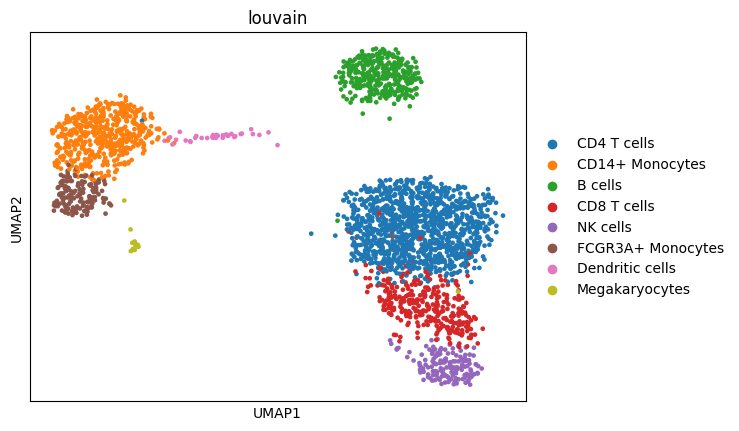

In [4]:
sc.pl.umap(adata, color="louvain")

Here we use a

We need a minimum of 3 inputs types to run DAARIO: the actual data matrices, an optional normalization factor and a likelihood type. We have a simple parser function for AnnData objects but it is always better to understand how to do it explicitly:

In [9]:
# input_matrix, norm_factor, distribution_type = daa.get_input_params_adata(adata) 
# is the same as

input_data = [adata.X]
normalization = [np.ones(adata.X.shape[0])] # If you have a normalization factor for each cell, you can provide it here
input_distribution = ["G"] # G for Gaussian, P for Poisson, NB for Negative Binomial

# As a quick note, as you see DAARIO is developed for multi-modal data, 
# so even if you use it for a single modality the inputs are always lists.

Let's run the model with 6 archetypes and have a look at the output to understand what is going on:

In [23]:
res = daa.fit_DAARIO(
    input_data,
    normalization,
    input_distribution,    
    hidden_dims_enc_ind = [128], # Hidden dimensions of the encoder
    hidden_dims_enc_common = [64], # Hidden dimensions of the encoder
    hidden_dims_enc_pre_Z = [64, 32], # Hidden dimensions of the encoder before the Z layer
    hidden_dims_dec_common = [32, 64], # Hidden dimensions of the decoder
    hidden_dims_dec_last = [64, 128], # Hidden dimensions of the decoder last layer
    lr = 0.001, # Learning rate
    gamma_lr = 0.1, # Learning rate decay factor
    steps = 500,
    narchetypes = 3,
    batch_size = 512,
    CUDA = True
    )

ELBO: 4970955.50000  : 100%|██████████| 500/500 [00:52<00:00,  9.47it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


In [24]:
# Utility functions to add archetypes weights to the anndata object

adata, arc_names = daa.add_to_obs_adata(res, adata)

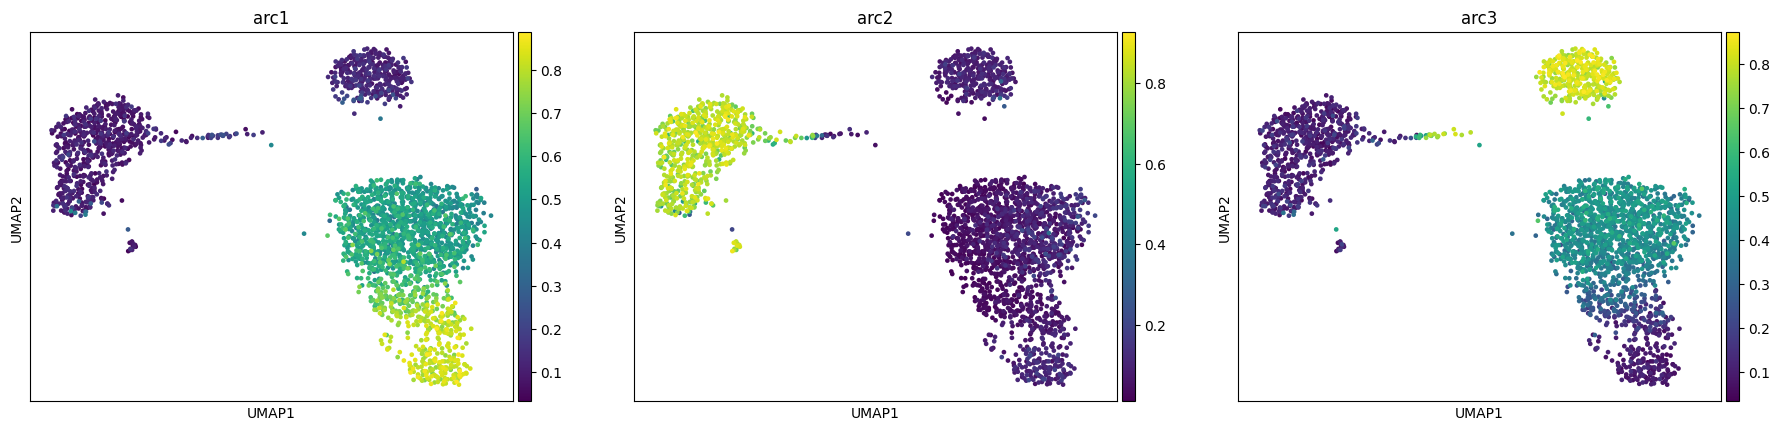

In [25]:
sc.pl.umap(adata, color=arc_names)

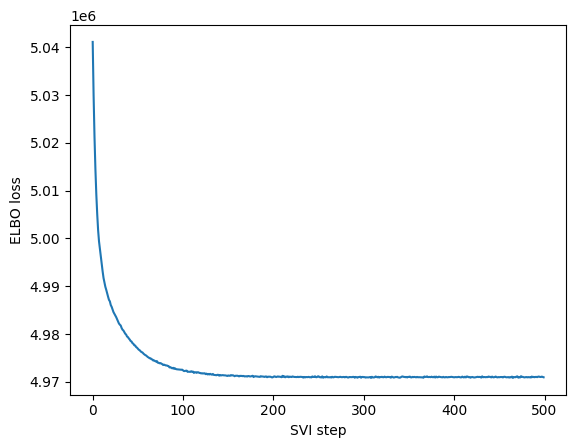

In [26]:
daa.plot_ELBO(res)

(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

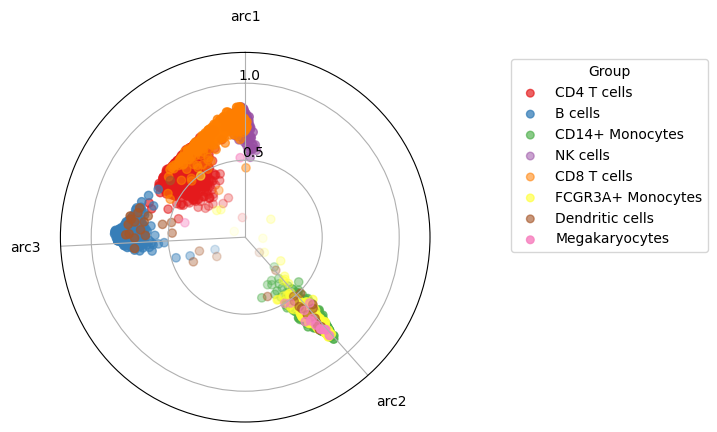

In [27]:

daa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [31]:
models  = {}

for i in range(2, 12):
    models[i] = daa.fit_DAARIO(
    input_data,
    normalization,
    input_distribution,    
    hidden_dims_enc_ind = [128], # Hidden dimensions of the encoder
    hidden_dims_enc_common = [64], # Hidden dimensions of the encoder
    hidden_dims_enc_pre_Z = [64, 32], # Hidden dimensions of the encoder before the Z layer
    hidden_dims_dec_common = [32, 64], # Hidden dimensions of the decoder
    hidden_dims_dec_last = [64, 128], # Hidden dimensions of the decoder last layer
    lr = 0.001, # Learning rate
    gamma_lr = 1, # Learning rate decay factor
    steps = 250,
    narchetypes = i,
    batch_size = 1024,
    CUDA = True
    )

ELBO: 9907476.00000  : 100%|██████████| 250/250 [00:13<00:00, 18.85it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
ELBO: 9881814.00000  : 100%|██████████| 250/250 [00:13<00:00, 19.07it/s]


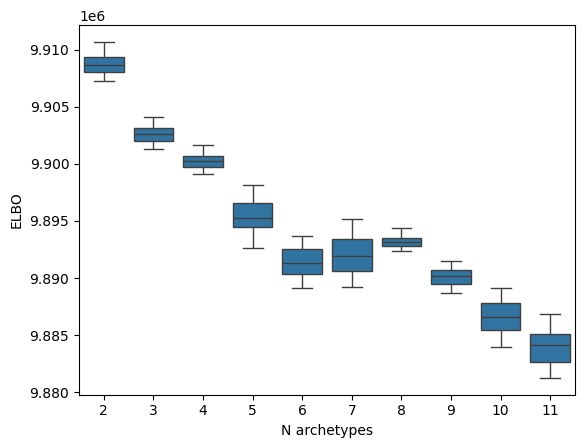

In [32]:
# warmup of 200 steps
daa.plot_ELBO_across_runs(models, 200)

In [ ]:
side_mat = pd.get_dummies(adata.obs["louvain"], prefix='louvain') 
side_mat = side_mat.to_numpy().astype(float)